# Modelling

In [34]:
import os
import math
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import re
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("white")
from scipy.ndimage.filters import gaussian_filter
import shap
import pickle
from math import cos, sin, asin, sqrt

from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.utils import shuffle
import xgboost as xgb
from xgboost import plot_importance

import tensorflow as tf    
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Input, concatenate, SimpleRNN, Dropout, Bidirectional, Embedding, GRU
from keras.callbacks import History
from keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
history = History()

In [35]:
df = pd.read_csv("C:\\Data\\Processed_M3\\Sites_10min_time_final.csv")

In [36]:
timeInterval = '10min_time'
# df.columns = ['date', 'site', timeInterval, 'occupancy0', 'speed0', 'volume0','dateTime', 'hour', 'dayOfWeek', 'dayType']
df.columns = ['date','site','timeInterval','occupancy0','speed0','volume0','dateTime','hour','dayOfWeek','dayType','density0','state0']
sites = set(df['site'])
dateTime = pd.to_datetime(df['dateTime'])
df['interval'] = [v.hour*6+int(v.minute/10) for v in dateTime]
df

,date,site,timeInterval,occupancy0,speed0,volume0,dateTime,hour,dayOfWeek,dayType,density0,state0,interval
0,2016-07-01,14005 WB P0,00:00:00,0.000000,100.000000,67.728571,2016-07-01 00:00:00,0,4,0,0.000000,0.0,0
1,2016-07-01,14005 WB P0,00:10:00,0.000000,100.000000,62.821429,2016-07-01 00:10:00,0,4,0,0.000000,0.0,1
2,2016-07-01,14005 WB P0,00:20:00,0.000000,100.000000,53.171429,2016-07-01 00:20:00,0,4,0,0.000000,0.0,2
3,2016-07-01,14005 WB P0,00:30:00,0.000000,100.000000,51.971429,2016-07-01 00:30:00,0,4,0,0.000000,0.0,3
4,2016-07-01,14005 WB P0,00:40:00,0.000000,100.000000,44.350000,2016-07-01 00:40:00,0,4,0,0.000000,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51403,2016-08-21,14063 WB P0,23:10:00,0.890000,97.012222,62.000000,2016-08-21 23:10:00,23,6,1,1.260833,0.0,139
51404,2016-08-21,14063 WB P0,23:20:00,0.436667,96.243056,78.750000,2016-08-21 23:20:00,23,6,1,0.618611,0.0,140
51405,2016-08-21,14063 WB P0,23:30:00,0.490000,96.452778,36.000000,2016-08-21 23:30:00,23,6,1,0.694167,0.0,141
51406,2016-08-21,14063 WB P0,23:40:00,0.520000,96.370833,70.687500,2016-08-21 23:40:00,23,6,1,0.736667,0.0,142


## Features

In [37]:
# The lag is the time distance between time-factors and time-target
# If the lag is 0, we say we try to use the data 10 mins ago to forecast the now traffic condition
# If the lag is 2, we say we try to use the data 30 mins ago to forecast the now traffic condition
# If the lag is 5, we say we try to use the data 60 mins ago to forecast the now traffic condition

window = 6*10
lag = 2 # lag 0 means the label is 10 mins later
lag = lag + window

# sites = ['14005 WB P0', '14017 WB P0', '14025 WB P0', '14035 WB P0', '14045 WB P0', '14055 WB P0', '14061 WB P0']
# # sites = ['14025 WB P0']
# sites = ['14025 WB P0', '14035 WB P0', '14045 WB P0', '14055 WB P0']

# lag_names = ['volume'+str(t) for t in range(lag+1)]
volume_names = 'volume'+str(lag)
hour_names = 'hour'+str(lag)
dayOfWeek_names = 'dayOfWeek'+str(lag)
interval_names = 'interval'+str(lag)
dayType_names = 'dayType'+str(lag)
data_features = [volume_names, hour_names, dayOfWeek_names, interval_names, dayType_names]

column_names = list(df.columns.values) + data_features
print(column_names)

data = pd.DataFrame()
for site in sites:
    df1 = df[df['site']==site]
    df1.sort_values('dateTime')
    # df1 = pd.concat([df1]+ [df1['volume0'].shift(t) for t in range(lag+1)], axis=1)
    df1 = pd.concat([df1]+ [df1['volume0'].shift(lag)], axis=1)
    df1 = pd.concat([df1]+ [df1['hour'].shift(lag)], axis=1)
    df1 = pd.concat([df1]+ [df1['dayOfWeek'].shift(lag)], axis=1)
    df1 = pd.concat([df1]+ [df1['interval'].shift(lag)], axis=1)
    df1 = pd.concat([df1]+ [df1['dayType'].shift(lag)], axis=1)
    data = data.append(df1)
data.columns = column_names
#data = data.dropna()

features = ['volume' + str(lag)]
features_name = 'volume' + str(lag)
aux_features = []#[interval_names, dayType_names]
columns = features + aux_features
data

['date', 'site', 'timeInterval', 'occupancy0', 'speed0', 'volume0', 'dateTime', 'hour', 'dayOfWeek', 'dayType', 'density0', 'state0', 'interval', 'volume62', 'hour62', 'dayOfWeek62', 'interval62', 'dayType62']


,date,site,timeInterval,occupancy0,speed0,volume0,dateTime,hour,dayOfWeek,dayType,density0,state0,interval,volume62,hour62,dayOfWeek62,interval62,dayType62
720,2016-07-01,14055 WB P0,00:00:00,0.92625,83.137500,136.000,2016-07-01 00:00:00,0,4,0,1.312188,0.0,0,NaN,NaN,NaN,NaN,NaN
721,2016-07-01,14055 WB P0,00:10:00,1.24000,85.017143,168.000,2016-07-01 00:10:00,0,4,0,1.756667,0.0,1,NaN,NaN,NaN,NaN,NaN
722,2016-07-01,14055 WB P0,00:20:00,0.63750,91.635556,104.000,2016-07-01 00:20:00,0,4,0,0.903125,0.0,2,NaN,NaN,NaN,NaN,NaN
723,2016-07-01,14055 WB P0,00:30:00,0.72500,86.256746,108.000,2016-07-01 00:30:00,0,4,0,1.027083,0.0,3,NaN,NaN,NaN,NaN,NaN
724,2016-07-01,14055 WB P0,00:40:00,0.78875,89.008889,114.000,2016-07-01 00:40:00,0,4,0,1.117396,0.0,4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50827,2016-08-21,14025 WB P0,23:10:00,1.11500,97.785278,196.000,2016-08-21 23:10:00,23,6,1,1.579583,0.0,139,1408.0,12.0,6.0,77.0,1.0
50828,2016-08-21,14025 WB P0,23:20:00,1.21500,96.938611,200.000,2016-08-21 23:20:00,23,6,1,1.721250,0.0,140,1246.0,13.0,6.0,78.0,1.0
50829,2016-08-21,14025 WB P0,23:30:00,0.77750,96.207778,309.750,2016-08-21 23:30:00,23,6,1,1.101458,0.0,141,1248.0,13.0,6.0,79.0,1.0
50830,2016-08-21,14025 WB P0,23:40:00,0.70625,99.625694,277.125,2016-08-21 23:40:00,23,6,1,1.000521,0.0,142,1282.0,13.0,6.0,80.0,1.0


## Evaluation

In [38]:
def evaluate_model(y_pred_train, y_pred_test, y_train_true, y_test_true, y_base_train, y_base_test):
    """
    Function for calculating accuracy metrics. Inputs are list of predictions.
    """
    results = {}
    
    results['MAE train'] = mean_absolute_error(y_pred_train, y_train_true) 
    results['MAE test'] = mean_absolute_error(y_pred_test, y_test_true)
    results['MAE train base'] = mean_absolute_error(y_base_train, y_train_true)
    results['MAE test base'] = mean_absolute_error(y_base_test, y_test_true)
    
    results['MRE test'] = mean_absolute_percentage_error(y_pred_test, y_test_true)
    results['RMSE test'] = math.sqrt(mean_squared_error(y_pred_test, y_test_true))
    
    #print('results', results)
    #print('y_base_train', y_base_train) # y_base_train, y_base_test are not dataframe anymore
    
    total_error_train, total_error_test = 0,0
    total_error_train_base, total_error_test_base = 0,0
    
    for i in range(0, len(y_train_true)):
        total_error_train_base += np.abs(y_base_train[i] - y_train_true[i])
        total_error_train += np.abs(y_pred_train[i] - y_train_true[i])
    
    for i in range(0, len(y_test_true)):
        total_error_test_base += np.abs(y_base_test[i] - y_test_true[i])
        total_error_test += np.abs(y_pred_test[i] - y_test_true[i])
        
    results['Baseline model total error (on train set)'] = total_error_train_base
    results['Baseline model total error (on test set)'] = total_error_test_base
    results['Our model total error (on train set)'] = total_error_train
    results['Our model total error (on test set)'] = total_error_test 
    
    return results

In [39]:
def evaluate_model_ann(y_pred_train, y_pred_test, y_train_true, y_test_true, y_base_train, y_base_test):
    """
    Calculate mean squared error and total absolute error.
    evaluate_model(y_pred_train, y_pred_test, y_train_win, y_test_win, y_train_win_base, y_test_win_base)
    """
    results = {}
    
    results['train mae'] = mean_absolute_error(y_pred_train, y_train_true) 
    results['test mae'] = mean_absolute_error(y_pred_test, y_test_true)
    results['base train mae'] = mean_absolute_error(y_base_train, y_train_true)
    results['base test mae'] = mean_absolute_error(y_base_test, y_test_true)
    
    results['test mre'] = mean_absolute_percentage_error(y_pred_test, y_test_true)
    results['test rmse'] = mean_squared_error(y_pred_test, y_test_true)**.5
    
    error_train, error_test = [],[]
    error_train_base, error_test_base = [],[]
    
    for i in range(0, len(y_train_true)):
        error_train_base.append(np.abs(y_base_train[i] - y_train_true[i]))
        error_train.append(np.abs(y_pred_train[i] - y_train_true[i]))
    
    for i in range(0, len(y_test_true)):
        error_test_base.append(np.abs(y_base_test[i] - y_test_true[i]))
        error_test.append(np.abs(y_pred_test[i] - y_test_true[i]))
        
    results['base model train error'] = sum(error_train_base)
    results['base model test error'] = sum(error_test_base)
    results['our model train error'] = sum(error_train)
    results['our model test error'] = sum(error_test) 
    
    return results

In [40]:
def scatter_plot(y_test,y_pred_test,filePath):
    y_true = np.array(y_test)
    y_predicted = y_pred_test
    t = y_true
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_predicted, c=t, s=2, cmap='viridis')
    ax.plot([0,2000], [0,2000], 'k--', lw=4)
    ax.set_xlabel('True', fontsize=20)
    ax.set_ylabel('Predicted', fontsize=20)
    ax.xaxis.set_ticks(np.arange(0,2001,500))
    ax.yaxis.set_ticks(np.arange(0,2001,500))
    ax.tick_params(axis='both', labelsize=15, direction='inout',bottom=True, left=True)
    #regression line
    y_true, y_predicted = y_true.reshape(-1,1), y_predicted.reshape(-1,1)
    ax.annotate("R2 = {:.3f}".format(r2_score(y_true, y_predicted)), (0, 1400), fontsize=20)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig(filePath, bbox_inches='tight')
    plt.show()
    
def time_series_plot(y_test,y_pred_test,filePath):
    y_true = np.array(y_test)*6
    y_predicted = y_pred_test*6
    t = y_true
    fig, ax = plt.subplots(figsize=(10, 1.5))
    plt.plot(y_predicted, 'r', lw=.5)
    plt.plot(y_true, 'b', lw=.5)
    ax.set_ylabel('Flow', fontsize=12)

    ax.tick_params(axis='both', labelsize=12, direction='inout',bottom=True, left=True)
    ax.set_xticklabels([])
    plt.savefig(filePath, bbox_inches='tight')
    plt.show()
    
def show_time_scatter_plot(y_test,y_pred_test,title = "BiLSTM\\"):
    
    filePath = os.getcwd() + '\\Figs\\Scatter\\' + title
    imagePath = filePath + str(lag)+'_'+str(siteId)+'.png'
    if not os.path.exists(filePath):                                     
        os.makedirs(filePath)
    scatter_plot(y_test,y_pred_test,imagePath)
    
    filePath = os.getcwd() + '\\Figs\\TimeSeries\\' + title
    imagePath = filePath + str(lag)+'_'+str(siteId)+'.png'
    if not os.path.exists(filePath):
        os.makedirs(filePath)
    time_series_plot(y_test,y_pred_test,imagePath)

In [41]:
def feature_importance(x_train):
    crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']

    plt.figure(figsize = (6, 8))
    dt_importance_df = pd.DataFrame({"attributes": x_train.columns, "importance": dt.feature_importances_})
    dt_importance_df = dt_importance_df.sort_values("importance", ascending = True)
    dt_importance_df = dt_importance_df[dt_importance_df["importance"] > 0.001]
    plt.barh(dt_importance_df["attributes"], dt_importance_df["importance"], orientation = "horizontal", color = crayon)
    plt.xlabel("Feature Importance")

## Helper Functions for Normalising Data

In [42]:
def denormalise(predictions, scaler): #IMPORTANT: run this
    """
    Denormalise the predictions back to the previous scale. 
    """
    predictions = predictions.reshape(1,-1)
    pred = scaler.inverse_transform(predictions)
    
    return pred

In [43]:
def normalise(columns, df): #IMPORTANT: run this
    """
    Normalise variables given the list 'columns'. Used for SVR model. 
    
    Parameters:
    columns (list): list of strings containing feature names that need to be normalised.
    df (pandas dataframe): training data.
    
    """
    min_max_scaler = preprocessing.MinMaxScaler() #normalise to make variables comparable 
    final_df = pd.DataFrame(min_max_scaler.fit_transform(df[columns]), columns = columns)
    
    for col in df.columns: #add back the columns that weren't normalised
        if col not in columns: 
            final_df[col] = df[col].values
    
#     if 'volume' in columns: #also store the unnormalised travel times if necessary 
#         final_df['volume_unnorm'] = df['volume'].values
    return final_df, min_max_scaler

In [44]:
def create_auxiliary_input(train_x, test_x, features): 
    """
    Function to filter out only the auxiliary features. 
    Auxiliary features are all the other features other than the lagged features.
    
    """
    
    train_x_aux = train_x[features]
    test_x_aux = test_x[features]
    
    return train_x_aux, test_x_aux

## Helper Functions for Window the data

when we try to use 1 previous hour to preduct 1 further hour, the input window is 2.

Input window = history length (1) + lag (1)

In [45]:
def time_series_window_generator(x,y,lag,window,features_name):
    """
    1. we assume the train test is dataframe format, 
    and it contains both time series and other features
       
    2. we consider the base line is the first data points of input (only work for methods don't need normalization)
    
    3. for methods use normalization, we need to generate the baseline inside the method itself
    """
    # to create the correct window match
    # --------------------------------------
    #  1  2  3  4  5   6  ......
    # --------------  --
    #   features      label
    # 
    # this is a window 6, lag 1, data length 5 data match for time series.
    # didn't use this function for now because vol-x are manually generated

    local_x = x.copy()
    local_x_base = x[features_name].copy()
    local_y = y.copy()
    #print(y)
    
    index_x = local_x.index
    index_y = local_y.index
    data_n = len(x) - lag               # for 5 window 0 lag, means 5 data points predict 1 future hour.

    y_base_windowed = []
    y_windowed = []
    x_windowed = []
    
    for i in range(data_n):
        x_windowed.append(local_x[i : i+window].values.tolist())  # get features
        y_windowed.append(local_y[index_y[i]])
        y_base_windowed.append(local_x_base[index_x[i]])
#         if i == 0:
#             print('start_index ',index_x[0])
#             print("* processing the time series " + str(window) +" window in lag " + str(lag-window))
#             print('features: ', local_x[i : i+window], ' in ', str(index_x[0]),  ' to ', str(index_x[0]+window))
#             print('label: ', local_y[index_y[i]], ' in ', str(index_y[0]))

    # reshape to (n_sample, n_feautre * n_length) still 2d
    x_windowed = np.array(x_windowed)
    # print('input shape before:', x_windowed.shape)
    x_windowed = np.reshape(x_windowed, (x_windowed.shape[0],-1))
    # print('input shape after:', x_windowed.shape)
    
    return x_windowed, y_windowed, y_base_windowed

In [46]:
def prepare_nn_data(x,y,lag,window,time_feautre_name = 'volume1'):
    """
    Reformat data to appropriate form for the recurrent neural
    network.
    1. get time series data in array (n_sample,1,n_length)
    2. get aux data in array (n_sample,1,n_features)
    3. get y & y_base in array (n_sample,)
    
    to separate 1 and 2, use time_feautre_name
    """
    # separate 1 and 2
    print("==================")
    print("process ann data")
    local_x = x.copy()
    index_y = y.index
    time_feature_df = local_x[time_feautre_name]
    aux_feature_df = local_x.drop(time_feautre_name, axis=1)

    x_windowed = []
    x_windowed_aux = []
    y_base_windowed = []
    y_windowed = []
    
    data_n = len(x) - lag
    for i in range(data_n):
        x_windowed.append(time_feature_df[i : i+window].values.tolist())     # get time series features
        x_windowed_aux.append(aux_feature_df[i : i+window].values.tolist())  # get other time related features
        y_base_windowed.append(time_feature_df[i])                    # get first of input time slot data as baseline 
        y_windowed.append((y[index_y[i]]))                                   # get grand truth
        
    # reshape to (n_sample, 1 feautre)
    x_windowed = np.asarray(x_windowed).astype(np.float32)
    x_windowed_aux = np.asarray(x_windowed_aux).astype(np.float32)
    y_base_windowed = np.asarray(y_base_windowed).astype(np.float32)
    y_windowed = np.asarray(y_windowed).astype(np.float32)
    #print('before reshape for tensorflow usage')
    #print('input shape of time series:', x_windowed.shape)
    #print('input shape of aux features:', x_windowed_aux.shape)
    #print('sample input time series:',x_windowed[0])
    #print('sample input aux features::',x_windowed_aux[0])
    #print('target shape:',y_windowed.shape)
    #print('sample target:',y_windowed[0])
    
    x_windowed = np.reshape(x_windowed, (x_windowed.shape[0], 1, x_windowed.shape[1]))
    x_windowed_aux = np.reshape(x_windowed_aux, (x_windowed_aux.shape[0],1, -1))      # for merge must be n,1,m.
    y_base_windowed = np.reshape(y_base_windowed, (y_base_windowed.shape[0], 1))
    y_windowed = np.reshape(y_windowed, (y_windowed.shape[0], 1))
    #print('after reshape for tensorflow usage')
    #print('input shape of time series:', x_windowed.shape)
    #print('input shape of aux features:', x_windowed_aux.shape)
    #print('target shape:',y_windowed.shape)
    
    return x_windowed, x_windowed_aux, y_windowed, y_base_windowed

# Models

# Neural network models

The following sections use different neural networks, which are MLP, RNN, LSTM, GRU and BILSTM. However their general structure are same.

See below


In [47]:
# ################
# this model architecture actually is a 2 branch model
#  input1 time series               
#     |
#  RNN model        
#     |                       
#  RNN output     input2 other features
#     |                     |
#     -----------------------
#                |
#              Concat
#                |
#               MLP
#                |
#           final output


# RNN

14055 WB P0
process ann data
process ann data
train mae 66.627785
test mae 73.65225
base train mae 1134.657
base test mae 1128.5398
test mre 0.12423208
test rmse 111.97268343635201
base model train error [6469815.]
base model test error [1644282.5]
our model train error [379911.8]
our model test error [107311.38]
Model R square (train):  0.9815897337755971
Model R square (test):  0.9737650217774148
Base R square (train):  -2.0180046368566975
Base R square (test):  -2.0756287889437464


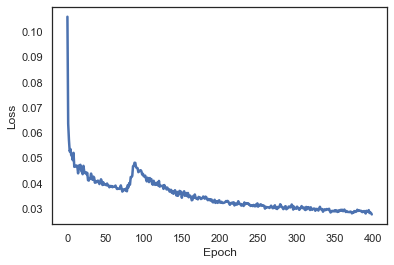

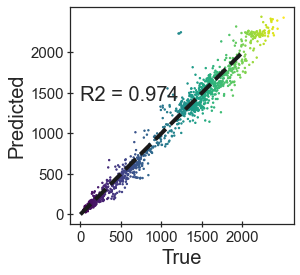

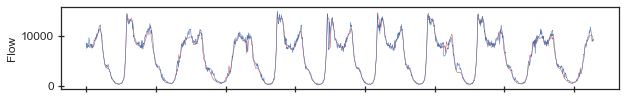

14011 WB P0
process ann data
process ann data
train mae 60.125603
test mae 65.60969
base train mae 812.0861
base test mae 812.2386
test mre 0.12575205
test rmse 95.04005117909502
base model train error [4630515.]
base model test error [1183431.5]
our model train error [342836.5]
our model test error [95593.32]
Model R square (train):  0.9715983191002909
Model R square (test):  0.9655389368174433
Base R square (train):  -1.8727845143995117
Base R square (test):  -1.9184532149500297


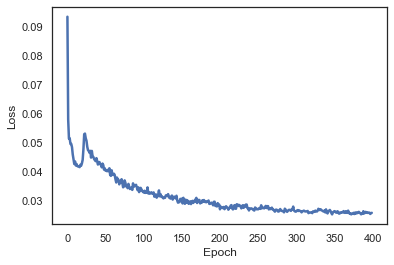

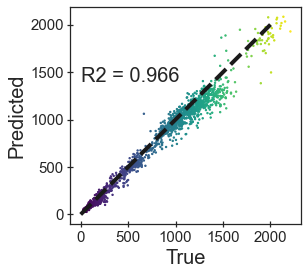

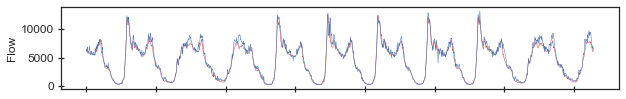

14005 WB P0
process ann data
process ann data
train mae 37.285408
test mae 40.837524
base train mae 448.28912
base test mae 468.28885
test mre 0.17171839
test rmse 56.520018145537385
base model train error [2556143.8]
base model test error [682296.75]
our model train error [212601.44]
our model test error [59500.258]
Model R square (train):  0.9672002942603355
Model R square (test):  0.9623816569797508
Base R square (train):  -1.9640844116713505
Base R square (test):  -2.0632778656913837


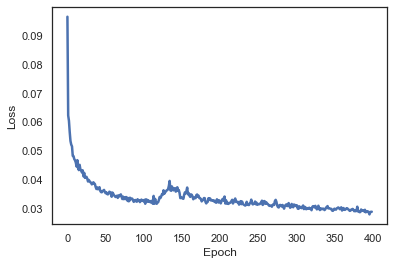

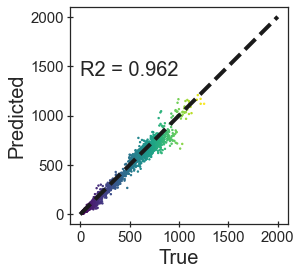

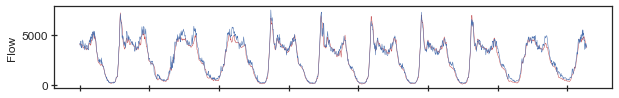

14063 WB P0
process ann data
process ann data
train mae 24.280313
test mae 25.742691
base train mae 345.53717
base test mae 340.35327
test mre 0.17874931
test rmse 39.06184530701363
base model train error [1970254.2]
base model test error [495894.8]
our model train error [138446.16]
our model test error [37507.105]
Model R square (train):  0.9720802667632975
Model R square (test):  0.9659506183517217
Base R square (train):  -1.9118604919200473
Base R square (test):  -1.977637756733054


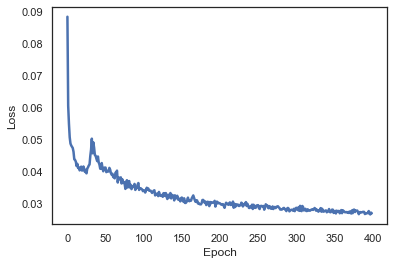

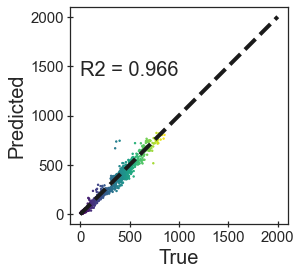

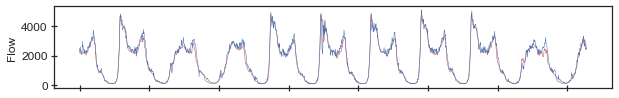

14049 WB P0
process ann data
process ann data
train mae 38.9819
test mae 41.10136
base train mae 601.7155
base test mae 606.55774
test mre 0.2113712
test rmse 58.11998046202571
base model train error [3430983.8]
base model test error [883754.75]
our model train error [222274.95]
our model test error [59884.668]
Model R square (train):  0.9788322616848013
Model R square (test):  0.975374875324986
Base R square (train):  -2.0486387706440774
Base R square (test):  -2.0969337349136743


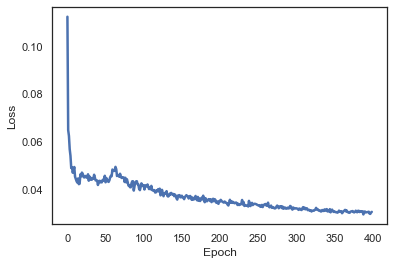

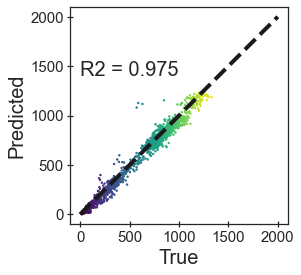

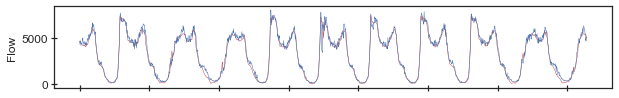

14037 WB P0
process ann data
process ann data
train mae 71.78989
test mae 75.920364
base train mae 993.52826
base test mae 990.5414
test mre 0.1334115
test rmse 114.93368927206461
base model train error [5665097.5]
base model test error [1443219.2]
our model train error [409345.8]
our model test error [110616.02]
Model R square (train):  0.9716459996685278
Model R square (test):  0.9643530785828388
Base R square (train):  -2.0390301150374635
Base R square (test):  -2.0755431762805903


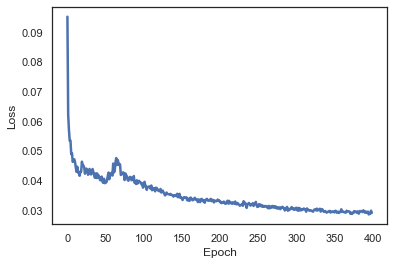

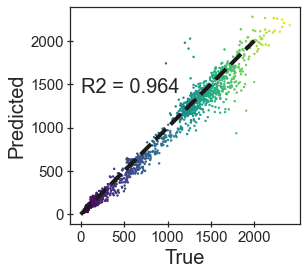

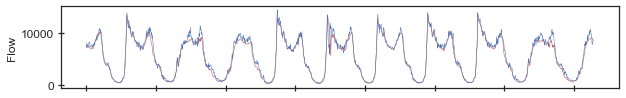

14025 WB P0
process ann data
process ann data
train mae 61.654427
test mae 67.68427
base train mae 973.205
base test mae 971.9262
test mre 0.17595568
test rmse 98.68338338469147
base model train error [5549214.]
base model test error [1416096.5]
our model train error [351553.47]
our model test error [98616.04]
Model R square (train):  0.9804079271736897
Model R square (test):  0.9734414523914378
Base R square (train):  -1.8937525468320326
Base R square (test):  -1.943155315263878


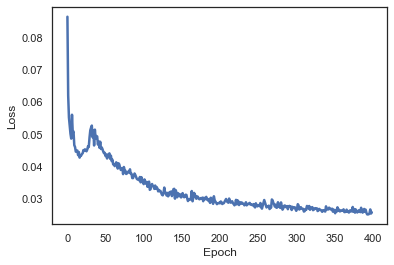

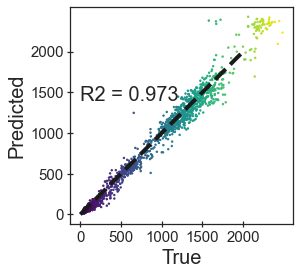

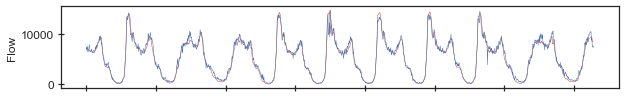

sums of MAE test /counter 55.79259327479771


In [48]:
final = pd.DataFrame()
MAE_RNN, MRE_RNN, RMSE_RNN = {},{},{}


for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    tmp = tmp.dropna()
    if len(tmp) == 0:
        print('error',siteId)
        continue

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    # ################
    # Section 2 : model
    # ################
    main_input = Input(shape = (1,window), dtype = 'float32', name = 'main_input')
    rnn_out = SimpleRNN(64,return_sequences=True, activation = 'linear',
                    kernel_regularizer=regularizers.l2(0.0001)) (main_input)

    aux_input = Input(shape=(train_x_aux.shape[1],train_x_aux.shape[2]), name = 'aux_input')
    x = concatenate([rnn_out, aux_input]) #concatenate auxiliary features with rnn output     

    #feed concatenated result into dense layers
    x = Dense(32, activation = 'relu') (x)
    x = Dense(16, activation = 'relu') (x)
    main_output = Dense(1, activation = 'linear', name = 'main_output') (x)

    model = Model(inputs = [main_input, aux_input], outputs = [main_output])    

    model.compile(loss='mean_absolute_error',  optimizer=Adam(learning_rate=0.001))    

    history = model.fit({'main_input': train_x, 'aux_input': train_x_aux}, 
                        {'main_output': train_y}, epochs=400, batch_size=32, shuffle = False, verbose=0)

    filename = os.getcwd() + "\\Models\\RNN\\RNN_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\RNN\\RNN_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)

    # ################
    # Section 3 : evaluation
    # ################
    ### visualise the loss over epochs 
    plt.plot(history.history["loss"][0:500], linewidth = 2.5) #plot first 100 validation losses 
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict({'main_input': train_x, 'aux_input': train_x_aux})
    y_pred_test_origin = model.predict({'main_input': test_x, 'aux_input': test_x_aux})

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)
    for key in res:
        print(key, res[key])
    print('Model R square (train): ', r2_score(train_y.flatten(), y_pred_train))  
    print('Model R square (test): ', r2_score(test_y.flatten(), y_pred_test))     # both are after norm
    print('Base R square (train): ', r2_score(train_y.flatten(), y_base_train))   # both are after norm
    print('Base R square (test): ', r2_score(test_y.flatten(), y_base_test))

    MAE_RNN[siteId] = res['test mae']
    MRE_RNN[siteId] = res['test mre']
    RMSE_RNN[siteId] = res['test rmse']

    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "RNN\\")
    
    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test = pd.Series(y_test)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)
    
final.to_csv('C:\\Data\\predicted_rnn.csv',index=False)

sums, counter = 0, 0
for key in MAE_RNN:
    sums += MAE_RNN[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)

# return MAE_RNN
    

# LSTM

14055 WB P0
process ann data
process ann data
MAE 80.395226
MRE 0.1572425
RMSE 117.17227817806352


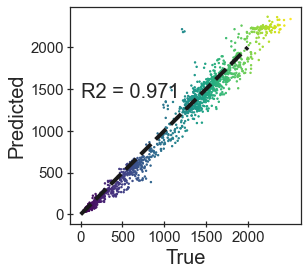

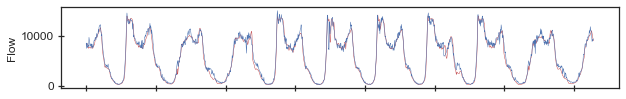

14011 WB P0
process ann data
process ann data
MAE 64.1081
MRE 0.12719764
RMSE 93.86172509335208


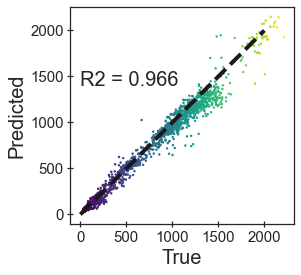

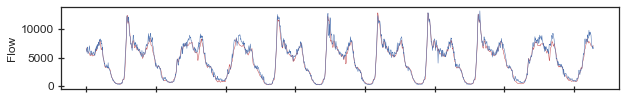

14005 WB P0
process ann data
process ann data
MAE 39.542496
MRE 0.1729542
RMSE 52.95377738237849


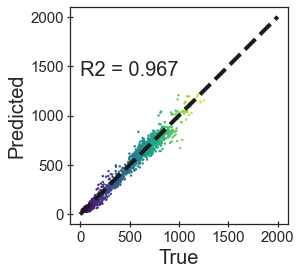

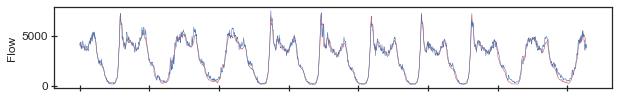

14063 WB P0
process ann data
process ann data
MAE 24.120316
MRE 0.14806066
RMSE 36.96797072297856


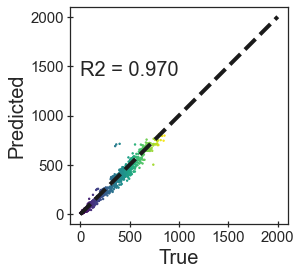

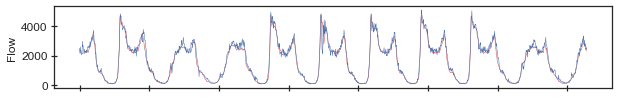

14049 WB P0
process ann data
process ann data
MAE 36.111027
MRE 0.1525223
RMSE 53.419834433827106


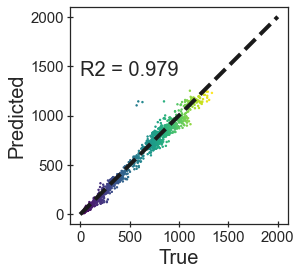

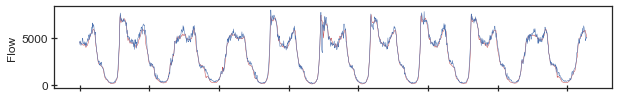

14037 WB P0
process ann data
process ann data
MAE 66.44369
MRE 0.13829571
RMSE 97.82362656364003


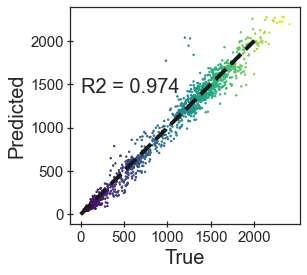

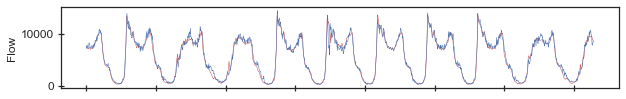

14025 WB P0
process ann data
process ann data
MAE 74.5792
MRE 0.16680656
RMSE 104.18948708363047


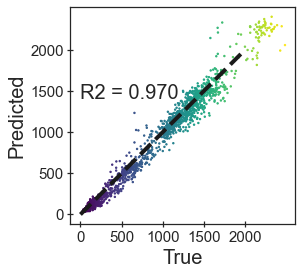

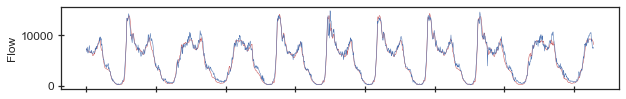

sums of MAE test /counter 55.042864663260325


In [49]:
final = pd.DataFrame()
MAE_LSTM, MRE_LSTM, RMSE_LSTM = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    if len(tmp) == 0:
        print('error',siteId)
        continue
    tmp = tmp.dropna()

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    # ################
    # Section 2 : model
    # ################
    main_input = Input(shape = (1,window), dtype = 'float32', name = 'main_input')
    lstm_out = LSTM(64,return_sequences=True, activation = 'relu',
                    kernel_regularizer=regularizers.l2(0.0001)) (main_input)

    aux_input = Input(shape=(train_x_aux.shape[1],train_x_aux.shape[2]), name = 'aux_input')
    x = concatenate([lstm_out, aux_input]) #concatenate auxiliary features with lstm output     

    #feed concatenated result into dense layers
    x = Dense(32, activation = 'relu') (x)
    x = Dense(16, activation = 'relu') (x)
    main_output = Dense(1, activation = 'linear', name = 'main_output') (x)

    model = Model(inputs = [main_input, aux_input], outputs = [main_output])    

    model.compile(loss='mean_absolute_error',  optimizer=Adam(learning_rate=0.001))    
    # model.summary()    

    history = model.fit({'main_input': train_x, 'aux_input': train_x_aux}, 
                        {'main_output': train_y}, epochs=400, batch_size=32, shuffle = False, verbose=0)

    filename = os.getcwd() + "\\Models\\LSTM\\LSTM_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\LSTM\\LSTM_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)

    # ################
    # Section 3 : evaluation
    # ################
    ### visualise the loss over epochs 
#     plt.plot(history.history["loss"][0:500], linewidth = 2.5) # plot first 100 validation losses 
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict({'main_input': train_x, 'aux_input': train_x_aux})
    y_pred_test_origin = model.predict({'main_input': test_x, 'aux_input': test_x_aux})

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)

    MAE_LSTM[siteId] = res['test mae']
    MRE_LSTM[siteId] = res['test mre']
    RMSE_LSTM[siteId] = res['test rmse']
    
    print('MAE', res['test mae'])
    print('MRE', res['test mre'])
    print('RMSE', res['test rmse'])

    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "LSTM\\")

    x_test_time = test[['dateTime','speed0','density0','state0','volume0']][:-lag]
    x_test_time = x_test_time.reset_index(drop=True)
    y_pred_test = pd.Series(y_pred_test)
    y_pred_test = y_pred_test.reset_index(drop=True)
    tmp1 = pd.concat([x_test_time,y_pred_test], axis=1)
    tmp1.columns = ['dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)

final.to_csv('C:\\Data\\predicted_lstm.csv',index=False)

sums, counter = 0, 0
for key in MAE_LSTM:
    sums += MAE_LSTM[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)



# GRU

14055 WB P0
process ann data
process ann data
MAE 73.306595
MRE 0.13458419
RMSE 110.32256947668279


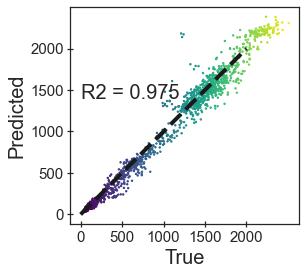

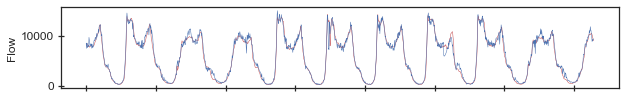

14011 WB P0
process ann data
process ann data
MAE 65.05434
MRE 0.16208652
RMSE 90.6544456473316


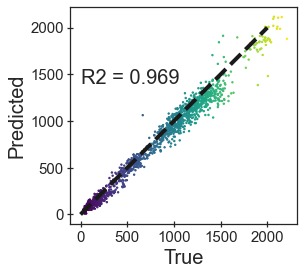

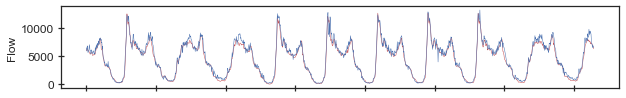

14005 WB P0
process ann data
process ann data
MAE 48.52476
MRE 0.24859501
RMSE 63.34563275754


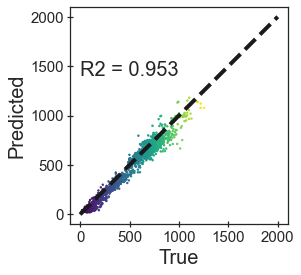

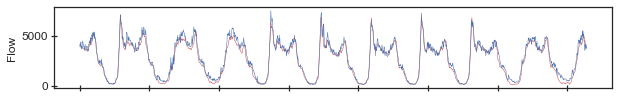

14063 WB P0
process ann data
process ann data
MAE 23.20844
MRE 0.15187608
RMSE 36.02384159256113


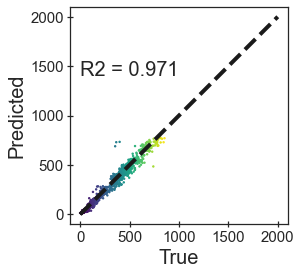

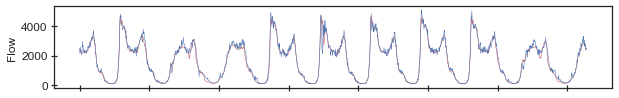

14049 WB P0
process ann data
process ann data
MAE 37.084946
MRE 0.13451909
RMSE 54.90681247933288


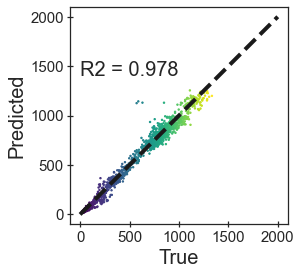

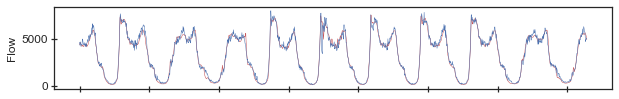

14037 WB P0
process ann data
process ann data
MAE 64.67767
MRE 0.14473665
RMSE 93.87136415229354


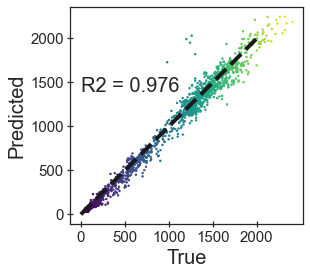

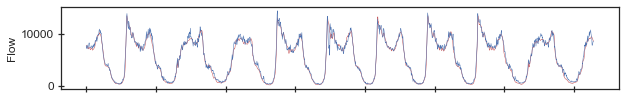

14025 WB P0
process ann data
process ann data
MAE 59.044525
MRE 0.12384467
RMSE 85.49005675917815


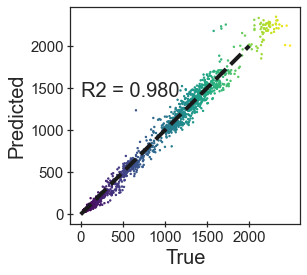

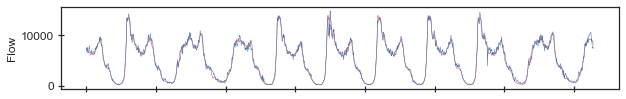

sums of MAE test /counter 52.98589679173061


In [50]:
final = pd.DataFrame()
MAE_GRU, MRE_GRU, RMSE_GRU = {},{},{}


for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    if len(tmp) == 0:
        print('error',siteId)
        continue
    tmp = tmp.dropna()

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    # ################
    # Section 2 : model
    # ################
    main_input = Input(shape = (1,window), dtype = 'float32', name = 'main_input')
    gru_out = GRU(64,return_sequences=True, activation = 'relu',
                    kernel_regularizer=regularizers.l2(0.0001)) (main_input)

    aux_input = Input(shape=(train_x_aux.shape[1],train_x_aux.shape[2]), name = 'aux_input')
    x = concatenate([gru_out, aux_input]) #concatenate auxiliary features with gru output     

    #feed concatenated result into dense layers
    x = Dense(32, activation = 'relu') (x)
    x = Dense(16, activation = 'relu') (x)
    main_output = Dense(1, activation = 'linear', name = 'main_output') (x)

    model = Model(inputs = [main_input, aux_input], outputs = [main_output])    

    model.compile(loss='mean_absolute_error',  optimizer=Adam(learning_rate=0.001))    
    # model.summary()    

    history = model.fit({'main_input': train_x, 'aux_input': train_x_aux}, 
                        {'main_output': train_y}, epochs=400, batch_size=32, shuffle = False, verbose=0)

    filename = os.getcwd() + "\\Models\\GRU\\GRU_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\GRU\\GRU_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)

    # ################
    # Section 3 : evaluation
    # ################
    ### visualise the loss over epochs 
#     plt.plot(history.history["loss"][0:500], linewidth = 2.5) # plot first 100 validation losses 
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict({'main_input': train_x, 'aux_input': train_x_aux})
    y_pred_test_origin = model.predict({'main_input': test_x, 'aux_input': test_x_aux})

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)

    MAE_GRU[siteId] = res['test mae']
    MRE_GRU[siteId] = res['test mre']
    RMSE_GRU[siteId] = res['test rmse']
    
    print('MAE', res['test mae'])
    print('MRE', res['test mre'])
    print('RMSE', res['test rmse'])

    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "GRU\\")

    x_test_time = test[['dateTime','speed0','density0','state0','volume0']][:-lag]
    x_test_time = x_test_time.reset_index(drop=True)
    y_pred_test = pd.Series(y_pred_test)
    y_pred_test = y_pred_test.reset_index(drop=True)
    tmp1 = pd.concat([x_test_time,y_pred_test], axis=1)
    tmp1.columns = ['dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)

final.to_csv('C:\\Data\\predicted_gru.csv',index=False)

sums, counter = 0, 0
for key in MAE_GRU:
    sums += MAE_GRU[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)



# Bidirectional LSTM

14055 WB P0
process ann data
process ann data
train mae 82.29345
test mae 90.32052
base train mae 1134.657
base test mae 1128.5398
test mre 0.18720086
test rmse 132.98160557714363
base model train error [6469815.]
base model test error [1644282.5]
our model train error [469237.44]
our model test error [131596.92]
Model R square (train):  0.9738489852794341
Model R square (test):  0.9629967662084666
Base R square (train):  -2.0180046368566975
Base R square (test):  -2.0756287889437464


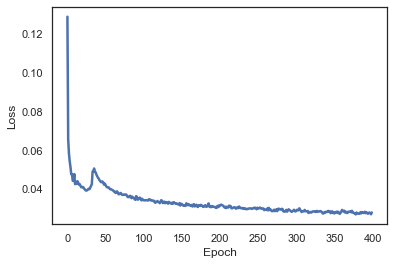

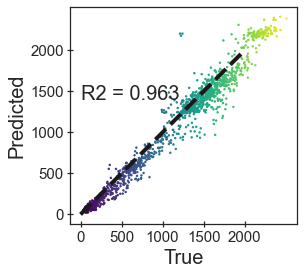

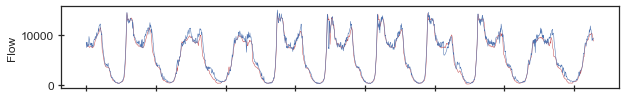

14011 WB P0
process ann data
process ann data
train mae 51.54785
test mae 56.907185
base train mae 812.0861
base test mae 812.2386
test mre 0.12840974
test rmse 78.54003196519434
base model train error [4630515.]
base model test error [1183431.5]
our model train error [293925.97]
our model test error [82913.73]
Model R square (train):  0.9804247872585834
Model R square (test):  0.9764659034176714
Base R square (train):  -1.8727845143995117
Base R square (test):  -1.9184532149500297


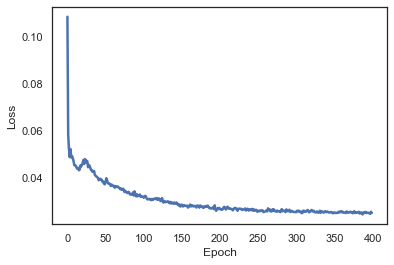

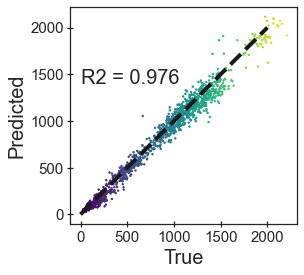

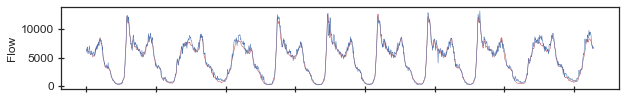

14005 WB P0
process ann data
process ann data
train mae 37.22991
test mae 39.151493
base train mae 448.28912
base test mae 468.28885
test mre 0.15331349
test rmse 53.26302153361772
base model train error [2556143.8]
base model test error [682296.75]
our model train error [212284.42]
our model test error [57043.72]
Model R square (train):  0.9690216616279458
Model R square (test):  0.9665922887794548
Base R square (train):  -1.9640844116713505
Base R square (test):  -2.0632778656913837


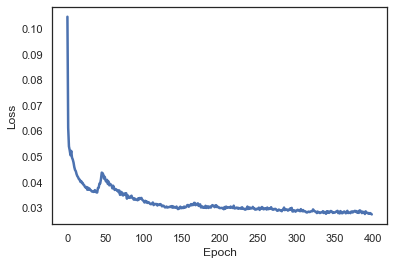

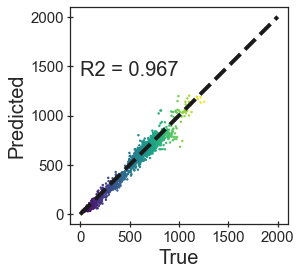

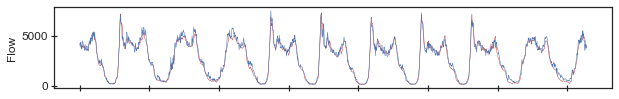

14063 WB P0
process ann data
process ann data
train mae 22.390696
test mae 23.075426
base train mae 345.53717
base test mae 340.35327
test mre 0.13806255
test rmse 35.6290276643173
base model train error [1970254.2]
base model test error [495894.8]
our model train error [127671.87]
our model test error [33620.906]
Model R square (train):  0.976709783804962
Model R square (test):  0.971672281515851
Base R square (train):  -1.9118604919200473
Base R square (test):  -1.977637756733054


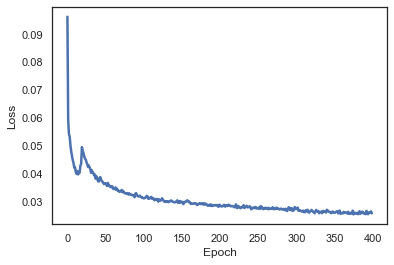

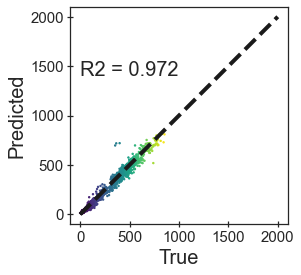

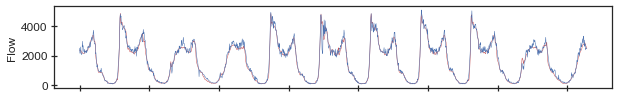

14049 WB P0
process ann data
process ann data
train mae 35.85402
test mae 36.369766
base train mae 601.7155
base test mae 606.55774
test mre 0.10599182
test rmse 54.83298060217728
base model train error [3430983.8]
base model test error [883754.75]
our model train error [204439.22]
our model test error [52990.77]
Model R square (train):  0.9798381859413102
Model R square (test):  0.978081479073638
Base R square (train):  -2.0486387706440774
Base R square (test):  -2.0969337349136743


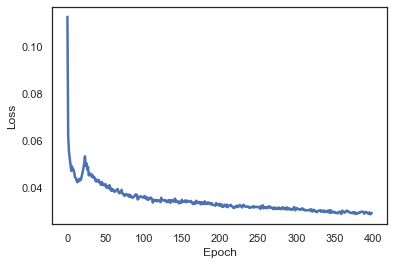

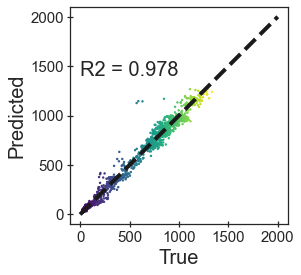

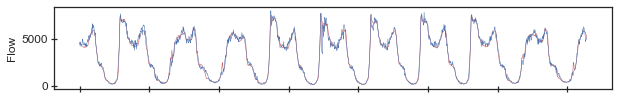

14037 WB P0
process ann data
process ann data
train mae 63.470055
test mae 66.44442
base train mae 993.52826
base test mae 990.5414
test mre 0.13397108
test rmse 97.06053302095812
base model train error [5665097.5]
base model test error [1443219.2]
our model train error [361907.34]
our model test error [96809.56]
Model R square (train):  0.9789306743093737
Model R square (test):  0.9745778240424943
Base R square (train):  -2.0390301150374635
Base R square (test):  -2.0755431762805903


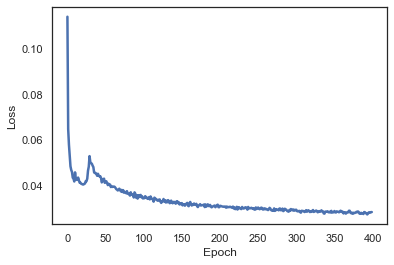

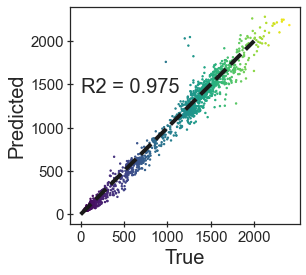

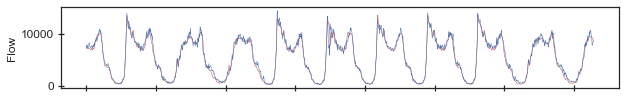

14025 WB P0
process ann data
process ann data
train mae 59.553123
test mae 63.29135
base train mae 973.205
base test mae 971.9262
test mre 0.13614061
test rmse 88.88768204611509
base model train error [5549214.]
base model test error [1416096.5]
our model train error [339572.22]
our model test error [92215.52]
Model R square (train):  0.9821407205814854
Model R square (test):  0.9784523749853492
Base R square (train):  -1.8937525468320326
Base R square (test):  -1.943155315263878


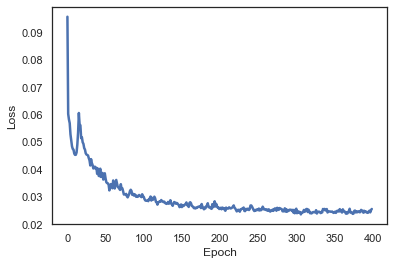

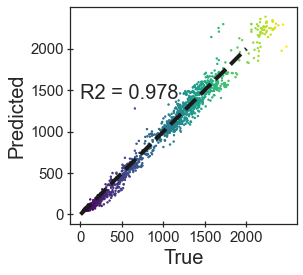

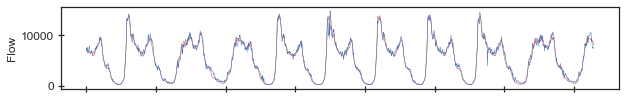

sums of MAE test /counter 53.65145138331822


In [51]:
final = pd.DataFrame()
MAE_BiLSTM, MRE_BiLSTM, RMSE_BiLSTM = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    if len(tmp) == 0:
        print('error',siteId)
        continue
    tmp = tmp.dropna()

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    # ################
    # Section 2 : model
    # ################
    main_input = Input(shape = (1,window), dtype = 'float32', name = 'main_input')
    lstm_out = Bidirectional(LSTM(64,return_sequences=True, activation = 'relu',
                    kernel_regularizer=regularizers.l2(0.0001))) (main_input)

    aux_input = Input(shape=(train_x_aux.shape[1],train_x_aux.shape[2]), name = 'aux_input')
    x = concatenate([lstm_out, aux_input]) #concatenate auxiliary features with lstm output     

    #feed concatenated result into dense layers
    x = Dense(32, activation = 'relu') (x)
    x = Dense(16, activation = 'relu') (x)
    main_output = Dense(1, activation = 'linear', name = 'main_output') (x)

    model = Model(inputs = [main_input, aux_input], outputs = [main_output])      


    model.compile(loss='mean_absolute_error',  optimizer=Adam(learning_rate=0.001))    
    # model.summary()    

    history = model.fit({'main_input': train_x, 'aux_input': train_x_aux}, 
                   {'main_output': train_y}, epochs=400, batch_size=32, shuffle = False, verbose=0)

    filename = os.getcwd() + "\\Models\\BiLSTM\\LSTM_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\BiLSTM\\LSTM_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)


    # ################
    # Section 3 : evaluation
    # ################
    ### visualise the loss over epochs 
    plt.plot(history.history["loss"][0:500], linewidth = 2.5) # plot first 100 validation losses 
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict({'main_input': train_x, 'aux_input': train_x_aux})
    y_pred_test_origin = model.predict({'main_input': test_x, 'aux_input': test_x_aux})

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)
    for key in res:
        print(key, res[key])
    print('Model R square (train): ', r2_score(train_y.flatten(), y_pred_train))  
    print('Model R square (test): ', r2_score(test_y.flatten(), y_pred_test))     # both are after norm
    print('Base R square (train): ', r2_score(train_y.flatten(), y_base_train))   # both are after norm
    print('Base R square (test): ', r2_score(test_y.flatten(), y_base_test))

    MAE_BiLSTM[siteId] = res['test mae']
    MRE_BiLSTM[siteId] = res['test mre']
    RMSE_BiLSTM[siteId] = res['test rmse']
    
    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "BiLSTM\\")

    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test = pd.Series(y_test)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)

final.to_csv('C:\\Data\\predicted_bilstm.csv',index=False)

sums, counter = 0, 0
for key in MAE_BiLSTM:
    sums += MAE_BiLSTM[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)


# Regression Tree

14055 WB P0
Best paramaters:  {'min_samples_leaf': 5, 'max_features': 6, 'max_depth': 10} 

MAE 96.54756422815288
MRE 0.13663419720596492
RMSE 154.48121905364505


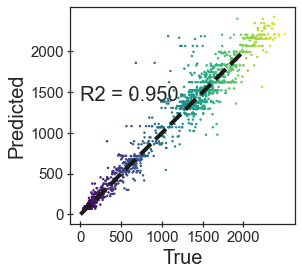

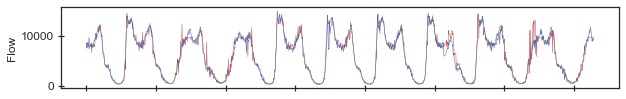

14011 WB P0
Best paramaters:  {'min_samples_leaf': 5, 'max_features': 6, 'max_depth': 10} 

MAE 74.11498129399905
MRE 0.1304664180409503
RMSE 115.16016828013537


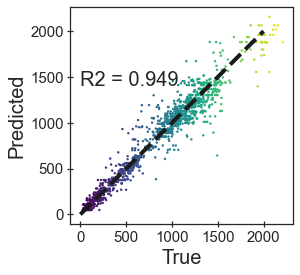

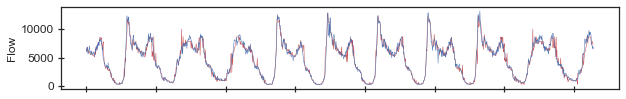

14005 WB P0
Best paramaters:  {'min_samples_leaf': 1, 'max_features': 6, 'max_depth': 8} 

MAE 48.47388089692552
MRE 0.1489416616928983
RMSE 69.04717141915033


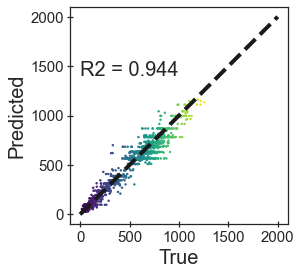

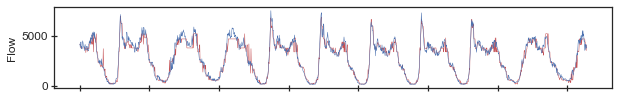

14063 WB P0
Best paramaters:  {'min_samples_leaf': 5, 'max_features': 6, 'max_depth': 10} 

MAE 28.319431370250694
MRE 0.14135015128087655
RMSE 51.28939260762725


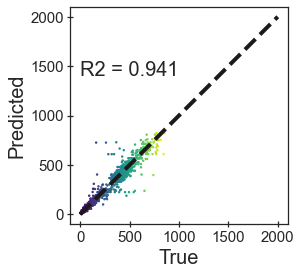

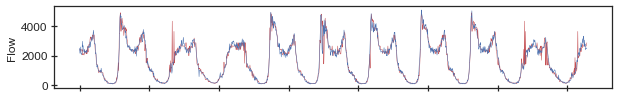

14049 WB P0
Best paramaters:  {'min_samples_leaf': 20, 'max_features': 6, 'max_depth': 10} 

MAE 45.44666796302806
MRE 0.11986189084731926
RMSE 81.69517110382405


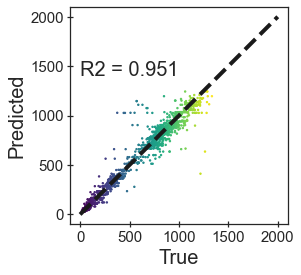

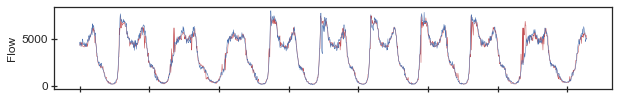

14037 WB P0
Best paramaters:  {'min_samples_leaf': 5, 'max_features': 6, 'max_depth': 10} 

MAE 76.36364675067215
MRE 0.11806330362341508
RMSE 122.93611647982286


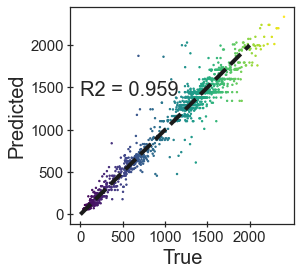

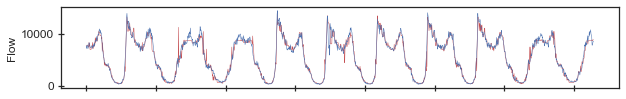

14025 WB P0
Best paramaters:  {'min_samples_leaf': 5, 'max_features': 6, 'max_depth': 10} 

MAE 76.60438694202462
MRE 0.12560340035485273
RMSE 123.62247353957338


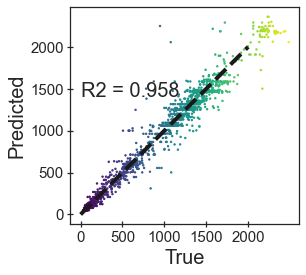

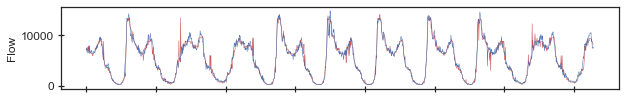

sums of MAE test /counter 63.69579420643614


In [57]:
final = pd.DataFrame()
MAE_RT, MRE_RT, RMSE_RT = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    tmp = tmp.dropna()
    
    if len(tmp) == 0:
        print('error',siteId)
        continue

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # we use 'vol - 0' as the prediction target
    # vol-x means how much hour before vol-0
    y_train = train['volume0'] #not normalised travel times 
    x_train = train[columns]
    y_test = test['volume0'] #not normalised travel times 
    x_test = test[columns]

    
    # please read the detail in time_series_window_generator function to see how baseline is defined
    x_train_win, y_train_win, y_train_win_base  = time_series_window_generator(x_train,y_train,lag,window,features_name)
    x_test_win, y_test_win, y_test_win_base = time_series_window_generator(x_test,y_test,lag,window,features_name)

    dt_model = DecisionTreeRegressor() 
    tuning_parameters = {
        #the number of features to consider when looking for best split.
        'max_features': [1,2,3,4,5,6],
        #minimum number of samples required to be at the leaf node.
        'min_samples_leaf': [1, 5, 10, 20],
        'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
    }
    dt_search = RandomizedSearchCV(dt_model, tuning_parameters, cv = 10, n_iter = 20,
                                  return_train_score = False, n_jobs = 4, 
                                  random_state = 20)

    #fitting the random forest model. Takes around 2 minutes to run.  
    dt_search.fit(x_train_win, y_train_win) 
    dt = dt_search.best_estimator_ 
    print("Best paramaters: ", dt_search.best_params_, '\n')

    ### Save regression tree model.
    pkl_folder = os.getcwd() + "\\Models\\RT\\" 
    pkl_filename = pkl_folder + "RT_model_lag_" + str(lag) + "_" + str(siteId) + ".pkl"
    if not os.path.exists(pkl_folder):                                       # create folder to store BFS results
        os.makedirs(pkl_folder)

    with open(pkl_filename, 'wb') as file:
        pickle.dump(dt_search, file)
    
#     pkl_folder = os.getcwd() + "\\Models\\RT\\" 
#     pkl_filename = pkl_folder + "RT_model_lag_" + str(lag) + "_" + str(siteId) + ".pkl"
#     dt_search= pickle.load(open(pkl_filename,'rb'))

    
    # forecasting results
    y_pred_train = dt_search.predict(x_train_win)
    y_pred_test = dt_search.predict(x_test_win)

    res = evaluate_model(y_pred_train, y_pred_test, y_train_win, y_test_win, y_train_win_base, y_test_win_base)

    MAE_RT[siteId] = res['MAE test']
    MRE_RT[siteId] = res['MRE test']
    RMSE_RT[siteId] = res['RMSE test']
    
    print('MAE', res['MAE test'])
    print('MRE', res['MRE test'])
    print('RMSE', res['RMSE test'])
    
    show_time_scatter_plot(y_test_win,y_pred_test, title = "RT\\")
    
    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test_win = pd.Series(y_test_win)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test_win,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)
    
final.to_csv('C:\\Data\\predicted_rt.csv',index=False)

sums, counter = 0, 0
for key in MAE_RT:
    sums += MAE_RT[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)

#return MAE_RT

# SVM

14055 WB P0


One or more of the test scores are non-finite: [0.95514792        nan        nan 0.96199894 0.95515625 0.95688646
 0.95575808 0.95774785 0.95490728 0.95616155 0.95933801 0.95842356
 0.96352776 0.95445278 0.95385643 0.95740177 0.95605054 0.95922961
 0.9538051         nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.2, 'C': 1} 

MAE 109.12441775306186
MRE 0.961892753968371
RMSE 142.7662711805367


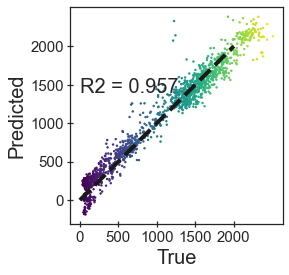

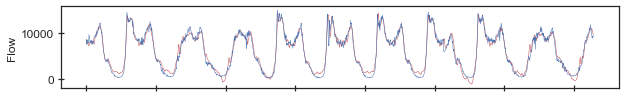

14011 WB P0


One or more of the test scores are non-finite: [0.94381992        nan        nan 0.94999797 0.94160998 0.94761857
 0.94462141 0.94939896 0.94181116 0.94468969 0.95455828 0.94507365
 0.95337924 0.94182788 0.94150972 0.94864153 0.95102361 0.95399778
 0.94188201        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.4, 'C': 0.8} 

MAE 84.8387409298058
MRE 0.35770119602901873
RMSE 107.07845347144789


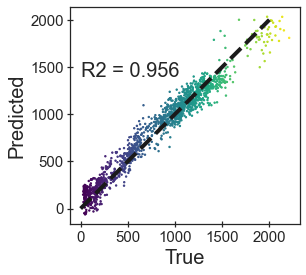

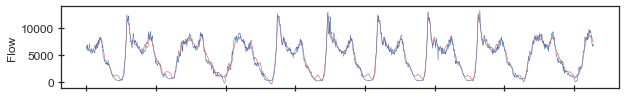

14005 WB P0


One or more of the test scores are non-finite: [0.93532732        nan        nan 0.94645189 0.93461402 0.93902374
 0.93616219 0.94113455 0.93426782 0.93644019 0.94621297 0.94196566
 0.94939834 0.93377789 0.93315042 0.9401699  0.9430124  0.94608427
 0.93362156        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.2, 'C': 1} 

MAE 48.70266485607245
MRE 0.38095227394728887
RMSE 62.40124187812972


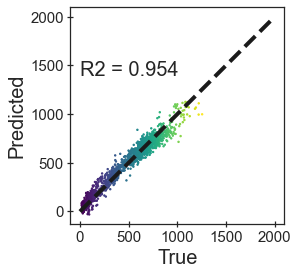

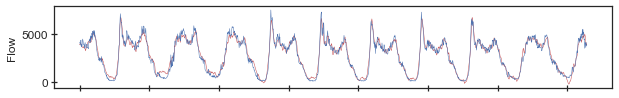

14063 WB P0


One or more of the test scores are non-finite: [0.94440338        nan        nan 0.94935332 0.94493769 0.94391854
 0.94504788 0.94505411 0.94504943 0.94512916 0.9473856  0.94052054
 0.95500946 0.94471141 0.94398465 0.94495693 0.94012835 0.94722982
 0.94169369        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.2, 'C': 1} 

MAE 33.415937010848424
MRE 0.7122047290478527
RMSE 46.7093859910514


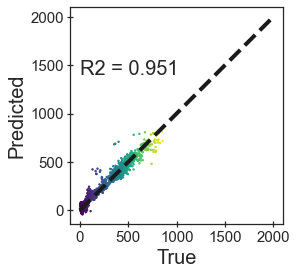

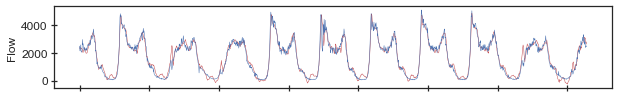

14049 WB P0


One or more of the test scores are non-finite: [0.95388621        nan        nan 0.95970205 0.95348505 0.95588531
 0.95442762 0.95599124 0.95362006 0.95444277 0.95828186 0.95614705
 0.96223437 0.95351875 0.95316718 0.9560002  0.9560277  0.95817295
 0.95225663        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.2, 'C': 1} 

MAE 61.52222831821509
MRE 0.32921711604871895
RMSE 79.66136674809174


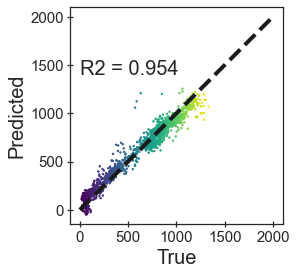

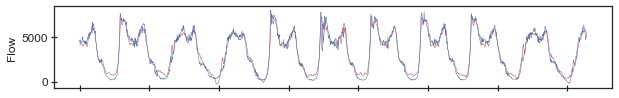

14037 WB P0


One or more of the test scores are non-finite: [0.94853037        nan        nan 0.9553269  0.94852071 0.95018461
 0.94957194 0.95177427 0.94862602 0.95024662 0.95295219 0.95061531
 0.95834846 0.94839943 0.94720565 0.95094198 0.95017755 0.95288021
 0.94684562        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.2, 'C': 1} 

MAE 96.49774959722953
MRE 0.4351391262223609
RMSE 128.14572863114816


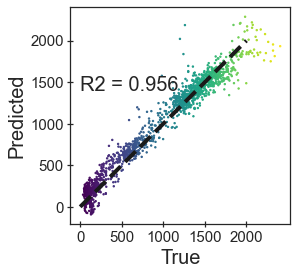

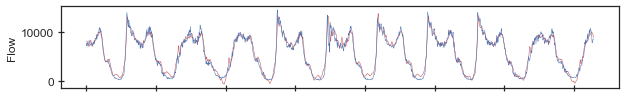

14025 WB P0


One or more of the test scores are non-finite: [0.95051307        nan        nan 0.95799412 0.94984028 0.95184423
 0.95049111 0.95241668 0.95014617 0.95042154 0.95942533 0.95425778
 0.96119216 0.95025377 0.95022037 0.95218599 0.95662777 0.95900253
 0.94816661        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.2, 'C': 1} 

MAE 91.52807366559954
MRE 0.7112050732378532
RMSE 121.83112372758521


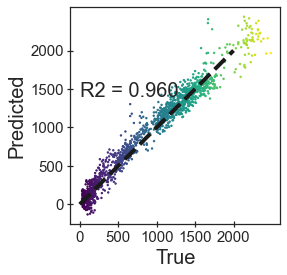

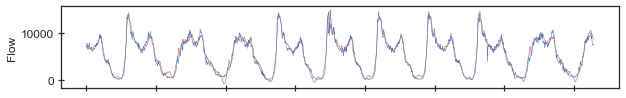

sums of MAE test /counter 75.08997316154752


In [58]:
final = pd.DataFrame()
MAE_SVR, MRE_SVR, RMSE_SVR = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    tmp = tmp.dropna()
    if len(tmp) == 0:
        print('error',siteId)
        continue

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)
    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    x_train_win, y_train_win, y_train_win_base  = time_series_window_generator(x_train,y_train,lag,window,features_name)
    x_test_win, y_test_win, y_test_win_base = time_series_window_generator(x_test,y_test,lag,window,features_name)

    ### make sure you feed normalised data only. 
    svr_model = SVR()
    tuning_parameters = {
        'kernel': ['rbf'],
        'gamma': [0.2, 0.4, 0.6, 0.8, 1],
        'C': [0, 0.2, 0.4, 0.6, 0.8, 1]

    }
    svr_search = RandomizedSearchCV(svr_model, tuning_parameters, cv = 10, n_iter = 20,
                                  return_train_score = False, n_jobs = 4, 
                                  random_state = 20)

    svr_search.fit(x_train_win, y_train_win)
    svr = svr_search.best_estimator_ 
    print("Best paramaters: ", svr_search.best_params_, '\n')

    ### Save the models.
    pkl_folder = os.getcwd() + "\\Models\\SVR\\" 
    pkl_filename = pkl_folder + "SVR_model_lag_" + str(lag) + "_" + str(siteId) + ".pkl"
    if not os.path.exists(pkl_folder):                                       # create folder to store BFS results
        os.makedirs(pkl_folder)

    pkl_folder = os.getcwd() + "\\Models\\SVR\\" 
    pkl_filename = pkl_folder + "SVR_model_lag_" + str(lag) + "_" + str(siteId) + ".pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(svr, file)

#     pkl_folder = os.getcwd() + "\\Models\\SVR\\" 
#     pkl_filename = pkl_folder + "SVR_model_lag_" + str(lag) + "_" + str(siteId) + ".pkl"
#     svr_search = pickle.load(open(pkl_filename,'rb'))

    # forecasting results
    y_pred_train_origin = svr_search.predict(x_train_win)
    y_pred_test_origin = svr_search.predict(x_test_win)

    # de-normalize the results
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    res = evaluate_model(y_pred_train, y_pred_test, y_train_win, y_test_win, y_train_win_base, y_test_win_base)

    # all results:
    # y_train_win : normalized   y_pred_train_origin : normalized   --- they need be compared at same level
    # y_test_win : not nrom   y_pred_test : not norm                --- they need be compared at same level
    # y_train_win : normalized    y_train_win_base : normalized     --- they need be compared at same level
    # y_test_win : not nrom    y_test_win_base : normalized         --- they cannot be compared at same level, because y_test_win_base comes from normalized x
    # thus
    y_test_win_base_from_x = test[features_name][:-lag]    #  y_test_win : not nrom    y_test_win_base_from_x : not nrom        --- they cannot be compared at same level

    MAE_SVR[siteId] = res['MAE test']
    MRE_SVR[siteId] = res['MRE test']
    RMSE_SVR[siteId] = res['RMSE test']
    
    print('MAE', res['MAE test'])
    print('MRE', res['MRE test'])
    print('RMSE', res['RMSE test'])

    show_time_scatter_plot(y_test_win,y_pred_test,title = "SVR\\")
    
    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test_win = pd.Series(y_test_win)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test_win,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)
    
final.to_csv('C:\\Data\\predicted_svr.csv',index=False)

sums, counter = 0, 0
for key in MAE_SVR:
    sums += MAE_SVR[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)



## Final statistics

In [53]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_RNN[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_RNN[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_RNN[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 55.79259327479771
sums of MRE test /counter 0.1601700293166297
sums of RMSE test /counter 82.04737874096854


In [54]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_LSTM[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_LSTM[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_LSTM[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 55.042864663260325
sums of MRE test /counter 0.15186851152351924
sums of RMSE test /counter 79.48409992255289


In [55]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_GRU[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_GRU[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_GRU[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 52.98589679173061
sums of MRE test /counter 0.15717745678765432
sums of RMSE test /counter 76.37353183784572


In [56]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_BiLSTM[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_BiLSTM[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_BiLSTM[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 53.65145138331822
sums of MRE test /counter 0.14044145068952016
sums of RMSE test /counter 77.31355462993191


In [59]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_RT[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_RT[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_RT[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 63.69579420643614
sums of MRE test /counter 0.13156014614946815
sums of RMSE test /counter 102.60453035482546


In [60]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_SVR[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_SVR[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_SVR[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 75.08997316154752
sums of MRE test /counter 0.555473181214495
sums of RMSE test /counter 98.37051023257013


## No Model

In [28]:
final = pd.DataFrame()
MAE_NM, MRE_NM, RMSE_NM = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    tmp = tmp.dropna()
    
    if len(tmp) == 0:
        print('error',siteId)
        continue

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 
    
    # we use 'vol - 0' as the prediction target
    # vol-x means how much hour before vol-0
    y_train = train['volume0'] #not normalised travel times 
    x_train = train[columns]
    y_test = test['volume0'] #not normalised travel times 
    x_test = test[columns]

    
    # please read the detail in time_series_window_generator function to see how baseline is defined
    x_train_win, y_train_win, y_train_win_base  = time_series_window_generator(x_train,y_train,lag,window,features_name)
    x_test_win, y_test_win, y_test_win_base = time_series_window_generator(x_test,y_test,lag,window,features_name)

    
    # forecasting results
    y_pred_train = x_train[columns[0]].values.tolist()[:-lag]
    y_pred_test = x_test[columns[0]].values.tolist()[:-lag]
    #print(y_pred_train)

    res = evaluate_model(y_pred_train, y_pred_test, y_train_win, y_test_win, y_train_win_base, y_test_win_base)

    MAE_NM[siteId] = res['MAE test']
    MRE_NM[siteId] = res['MRE test']
    RMSE_NM[siteId] = res['RMSE test']
    
    print('MAE', res['MAE test'])
    print('MRE', res['MRE test'])
    print('RMSE', res['RMSE test'])
    
    #show_time_scatter_plot(y_test_win,y_pred_test, title = "NM\\")
    
    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test_win = pd.Series(y_test_win)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test_win,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)
    
final.to_csv('C:\\Data\\predicted_nm.csv',index=False)

sums, counter = 0, 0
for key in MAE_NM:
    sums += MAE_NM[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)

14063 WB P0
MAE 227.5577698087432
MRE 5.441103122006991
RMSE 290.7717879818467
14005 WB P0
MAE 316.2717713212334
MRE 3.1029241847115343
RMSE 394.6874040812967
14049 WB P0
MAE 405.478981264637
MRE 3.727515603534091
RMSE 504.3097985184252
14055 WB P0
MAE 753.6767710772834
MRE 3.91717834889051
RMSE 943.0534783535269
14037 WB P0
MAE 668.1787431693989
MRE 3.1513536920474694
RMSE 828.6401734181379
14011 WB P0
MAE 569.0439890710381
MRE 3.6562906865644553
RMSE 714.504344674919
14025 WB P0
MAE 669.9843091334894
MRE 4.175345570672802
RMSE 845.4395312324768
sums of MAE test /counter 515.7417621208318


In [29]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_NM[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_NM[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_NM[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 515.7417621208318
sums of MRE test /counter 3.881673029775407
sums of RMSE test /counter 645.9152168943757


# MLP

In [55]:
final = pd.DataFrame()
MAE_MLP, MRE_MLP, RMSE_MLP = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    if len(tmp) == 0:
        print('error',siteId)
        continue
    tmp = tmp.dropna()

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    ################
    # Section 2 : model
    ################

    model = Sequential()
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001))
    history = model.fit(train_x, train_y, epochs=400, batch_size=32, shuffle = False, verbose=0)
    
    
    filename = os.getcwd() + "\\Models\\MLP\\MLP_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\MLP\\MLP_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)

    ################
    # Section 3 : evaluation
    ################
    ## visualise the loss over epochs 
    plt.plot(history.history["loss"][0:500], linewidth = 2.5) # plot first 100 validation losses 
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict(train_x)
    y_pred_test_origin = model.predict( test_x)

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)
    for key in res:
        print(key, res[key])

    MAE_MLP[siteId] = res['test mae']
    MRE_MLP[siteId] = res['test mre']
    RMSE_MLP[siteId] = res['test rmse']
    
    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "MLP\\")

    x_test_time = test[['dateTime','speed0','density0','state0','volume0']][:-lag]
    x_test_time = x_test_time.reset_index(drop=True)
    y_pred_test = pd.Series(y_pred_test)
    y_pred_test = y_pred_test.reset_index(drop=True)
    tmp1 = pd.concat([x_test_time,y_pred_test], axis=1)
    tmp1.columns = ['dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)

final.to_csv('C:\\Data\\predicted_mlp.csv',index=False)

sums, counter = 0, 0
for key in MAE_MLP:
    sums += MAE_MLP[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)

